## Library 

In [1]:
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle
import os
from collections import OrderedDict
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
palette: str = "husl"
grouped: str = "account_type"
default_value: str = "unknown"
warnings.filterwarnings('ignore')
%matplotlib inline

## Function Created 


In [2]:
# Distribution
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
# Correlation matrix
def plotCorrelationMatrix(df):
    corrs = df.corr()
    corrs = abs(corrs)
    cols_10 = corrs.nlargest(9, 'bot_or_not')['bot_or_not'].index
    corrs_10 = df[cols_10].corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corrs_10, annot=True)
    plt.show()

In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [5]:
# encoding
def convert_bool_to_int(data: pd.DataFrame, boolean_cols: list):
    try:
        for col in boolean_cols:
            data[col] = data[col].astype(int)
    except Exception as e:
        print(e)
    return data

In [6]:
# popularity=log(1+friends_cnt)*log(1+followers_cnt)
def popularity_metric(friends_count: int, followers_count: int):
    return np.round(np.log(1+friends_count) * np.log(1+followers_count), 3)
def compute_popularity_metric(row):
    return popularity_metric(friends_count=row["friends_count"],
                             followers_count=row["followers_count"])

In [7]:
def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    try:
        labels: list = df[column].unique().tolist()
        colors: list = sns.color_palette(palette, len(labels))
        data_labels: dict = dict(zip(labels, colors))
    except Exception as e:
        logger.error(e)
    return data_labels

In [8]:
def plot_multiple_histograms(data: pd.DataFrame,
                             grouped_col: str,
                             target_col: str,
                             data_labels: dict):
    plt.figure(figsize=(12, 10))
    title = "\n"
    labels: list = list(data_labels.keys())
    for j, i in enumerate(labels):
        x = data.loc[data[grouped_col] == i, target_col]
        mu_x = round(float(np.mean(x)), 3)
        sigma_x = round(float(np.std(x)), 3)
        ax = sns.distplot(x, color=data_labels.get(i), label=i, hist_kws=dict(alpha=.1),
                          kde_kws={'linewidth': 2})
        ax.axvline(mu_x, color=data_labels.get(i), linestyle='--')
        ax.set(xlabel=f"{target_col.title()}", ylabel='Density')
        title += f"Parameters {str(i)}: $G(\mu=$ {mu_x}, $\sigma=$ {sigma_x} \n"
        ax.set_title(title)
    plt.legend(title="Account Type")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:
def create_time_bar(df): # account creatation time bar chart
    df_tmp = df.groupby(['created_at', 'account_type'])['created_at'].count().unstack('account_type')
    df_tmp.plot(kind='bar', stacked=True, width=0.9, align='edge')
    plt.ylabel('number of accounts created')
    plt.show()

In [10]:
def verified_bar(df): # verified bar chart
    df_tmp = df.groupby(['account_type', 'verified'])['account_type'].count().unstack('verified')
    df_tmp.plot(kind='bar', stacked=True)
    plt.show()

In [11]:
def encode_bot_or_not(row): # y encoding
    if row['account_type'] == 'human':
        return 0
    return 1

In [12]:
def data_to_dataframe(): 
    Url = "https://raw.githubusercontent.com/chenchencherry/CS5344_twitter_bots_eda/main/twitter_human_bots_dataset.csv"
    df = pd.read_csv(Url)
    
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    # check missing value columns: description,lang,location,profile_background_image_url,profile_image_url; not very relevant can ignore
    print(df.isna().any()[lambda x: x])
    boolean_cols: list = ["default_profile", "default_profile_image",
                      "geo_enabled", "verified"]
    df = convert_bool_to_int(data=df, boolean_cols=boolean_cols)

    df["popularity"] = df.apply(compute_popularity_metric, axis=1)

    # extract hour number from created_at
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at'] = df['created_at'].map(lambda x: (x.hour))
    
    # new features
    df['favourites_rate'] = np.round(np.log(1 + (df['favourites_count'] / df['account_age_days'])), 3)
    df['follower_rate'] = np.round(np.log(1 + (df['favourites_count'] / df['account_age_days'])), 3)
    df['friend_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
    df['bot_or_not'] = df.apply(encode_bot_or_not, axis=1)
    
    return df

## Data Cleaning

In [13]:
df = data_to_dataframe()
human_df = df.loc[df['account_type'] == 'human', :]
bot_df = df.loc[df['account_type'] == 'bot', :]

description                     True
lang                            True
location                        True
profile_background_image_url    True
profile_image_url               True
dtype: bool


In [14]:
df.describe(include = 'all')

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,...,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,popularity,favourites_rate,follower_rate,friend_rate,bot_or_not
count,37438.000000,37438.000000,37438.000000,30182,37438.000000,3.743800e+04,3.743800e+04,37438.000000,3.743800e+04,29481,...,3.743800e+04,37438.000000,37438.000000,37438.000000,37438,37438.000000,37438.000000,37438.000000,37438.000000,37438.000000
unique,NaN,NaN,NaN,29945,NaN,NaN,NaN,NaN,NaN,48,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,en,...,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,21450,...,NaN,NaN,NaN,NaN,25013,NaN,NaN,NaN,NaN,NaN
mean,12.371040,0.419894,0.014905,NaN,12302.062183,3.703098e+05,4.445925e+03,0.456141,1.221536e+17,NaN,...,2.107339e+04,0.201693,6.891668,3022.128052,NaN,39.434665,0.906242,0.906242,0.258659,0.331882
std,7.325433,0.493548,0.121173,NaN,33923.650237,2.470829e+06,4.954520e+04,0.498079,3.004313e+17,NaN,...,6.732977e+04,0.401270,24.580116,1013.695870,NaN,34.098949,1.026090,1.026090,0.553802,0.470895
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,4.180000e+02,NaN,...,0.000000e+00,0.000000,0.000000,483.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,NaN,362.000000,3.500000e+01,3.700000e+01,0.000000,9.957306e+07,NaN,...,1.336250e+03,0.000000,0.495000,2316.250000,NaN,10.590000,0.121000,0.121000,0.014000,0.000000
50%,14.000000,0.000000,0.000000,NaN,2066.000000,3.650000e+02,2.960000e+02,0.000000,3.991474e+08,NaN,...,4.209000e+03,0.000000,1.488000,3219.000000,NaN,33.978500,0.509000,0.509000,0.095000,0.000000
75%,19.000000,1.000000,0.000000,NaN,8879.000000,8.440250e+03,8.930000e+02,1.000000,2.453826e+09,NaN,...,1.715375e+04,0.000000,5.528000,3888.000000,NaN,59.935500,1.376000,1.376000,0.257000,1.000000


In [15]:
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,...,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,popularity,favourites_rate,follower_rate,friend_rate,bot_or_not
0,21,0,0,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,0,787405734442958848,en,...,11041,0,7.870,1403,bot,11.864,0.003,0.003,0.003,1
1,5,0,0,Photographing the American West since 1980. I ...,536,860,880,0,796216118331310080,en,...,252,0,0.183,1379,human,45.827,0.328,0.328,0.494,0
2,5,0,0,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,1,875949740503859204,en,...,1001,0,0.864,1159,human,32.922,1.349,1.349,0.414,0
3,13,1,0,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,1,756119643622735875,en,...,1324,0,0.889,1489,human,40.325,1.897,1.897,0.354,0
4,16,0,0,Loan coach at @mancity & Aspiring DJ,88,753678,116,1,464781334,en,...,4202,1,1.339,3138,human,64.445,0.028,0.028,0.036,0


## Exploratory Data Analysis (EDA)

### Observation 1: bot account use more default profile, less than 0.7% human using default image，bot 4 times as human

In [16]:
len(human_df.loc[human_df['default_profile']==1])/len(human_df)

0.3189941230560109

In [17]:
len(bot_df.loc[bot_df['default_profile']==1])/len(bot_df)

0.6230181086519114

In [18]:
len(human_df.loc[human_df['default_profile_image']==1])/len(human_df)

0.006996361891816256

In [19]:
len(bot_df.loc[bot_df['default_profile_image']==1])/len(bot_df)

0.030824949698189136

### Observation 2: human enable ger info more than bot

In [20]:
len(human_df.loc[human_df['geo_enabled']==1])/len(human_df)

0.5741414464478471

In [21]:
len(bot_df.loc[bot_df['geo_enabled']==1])/len(bot_df)

0.21859154929577465

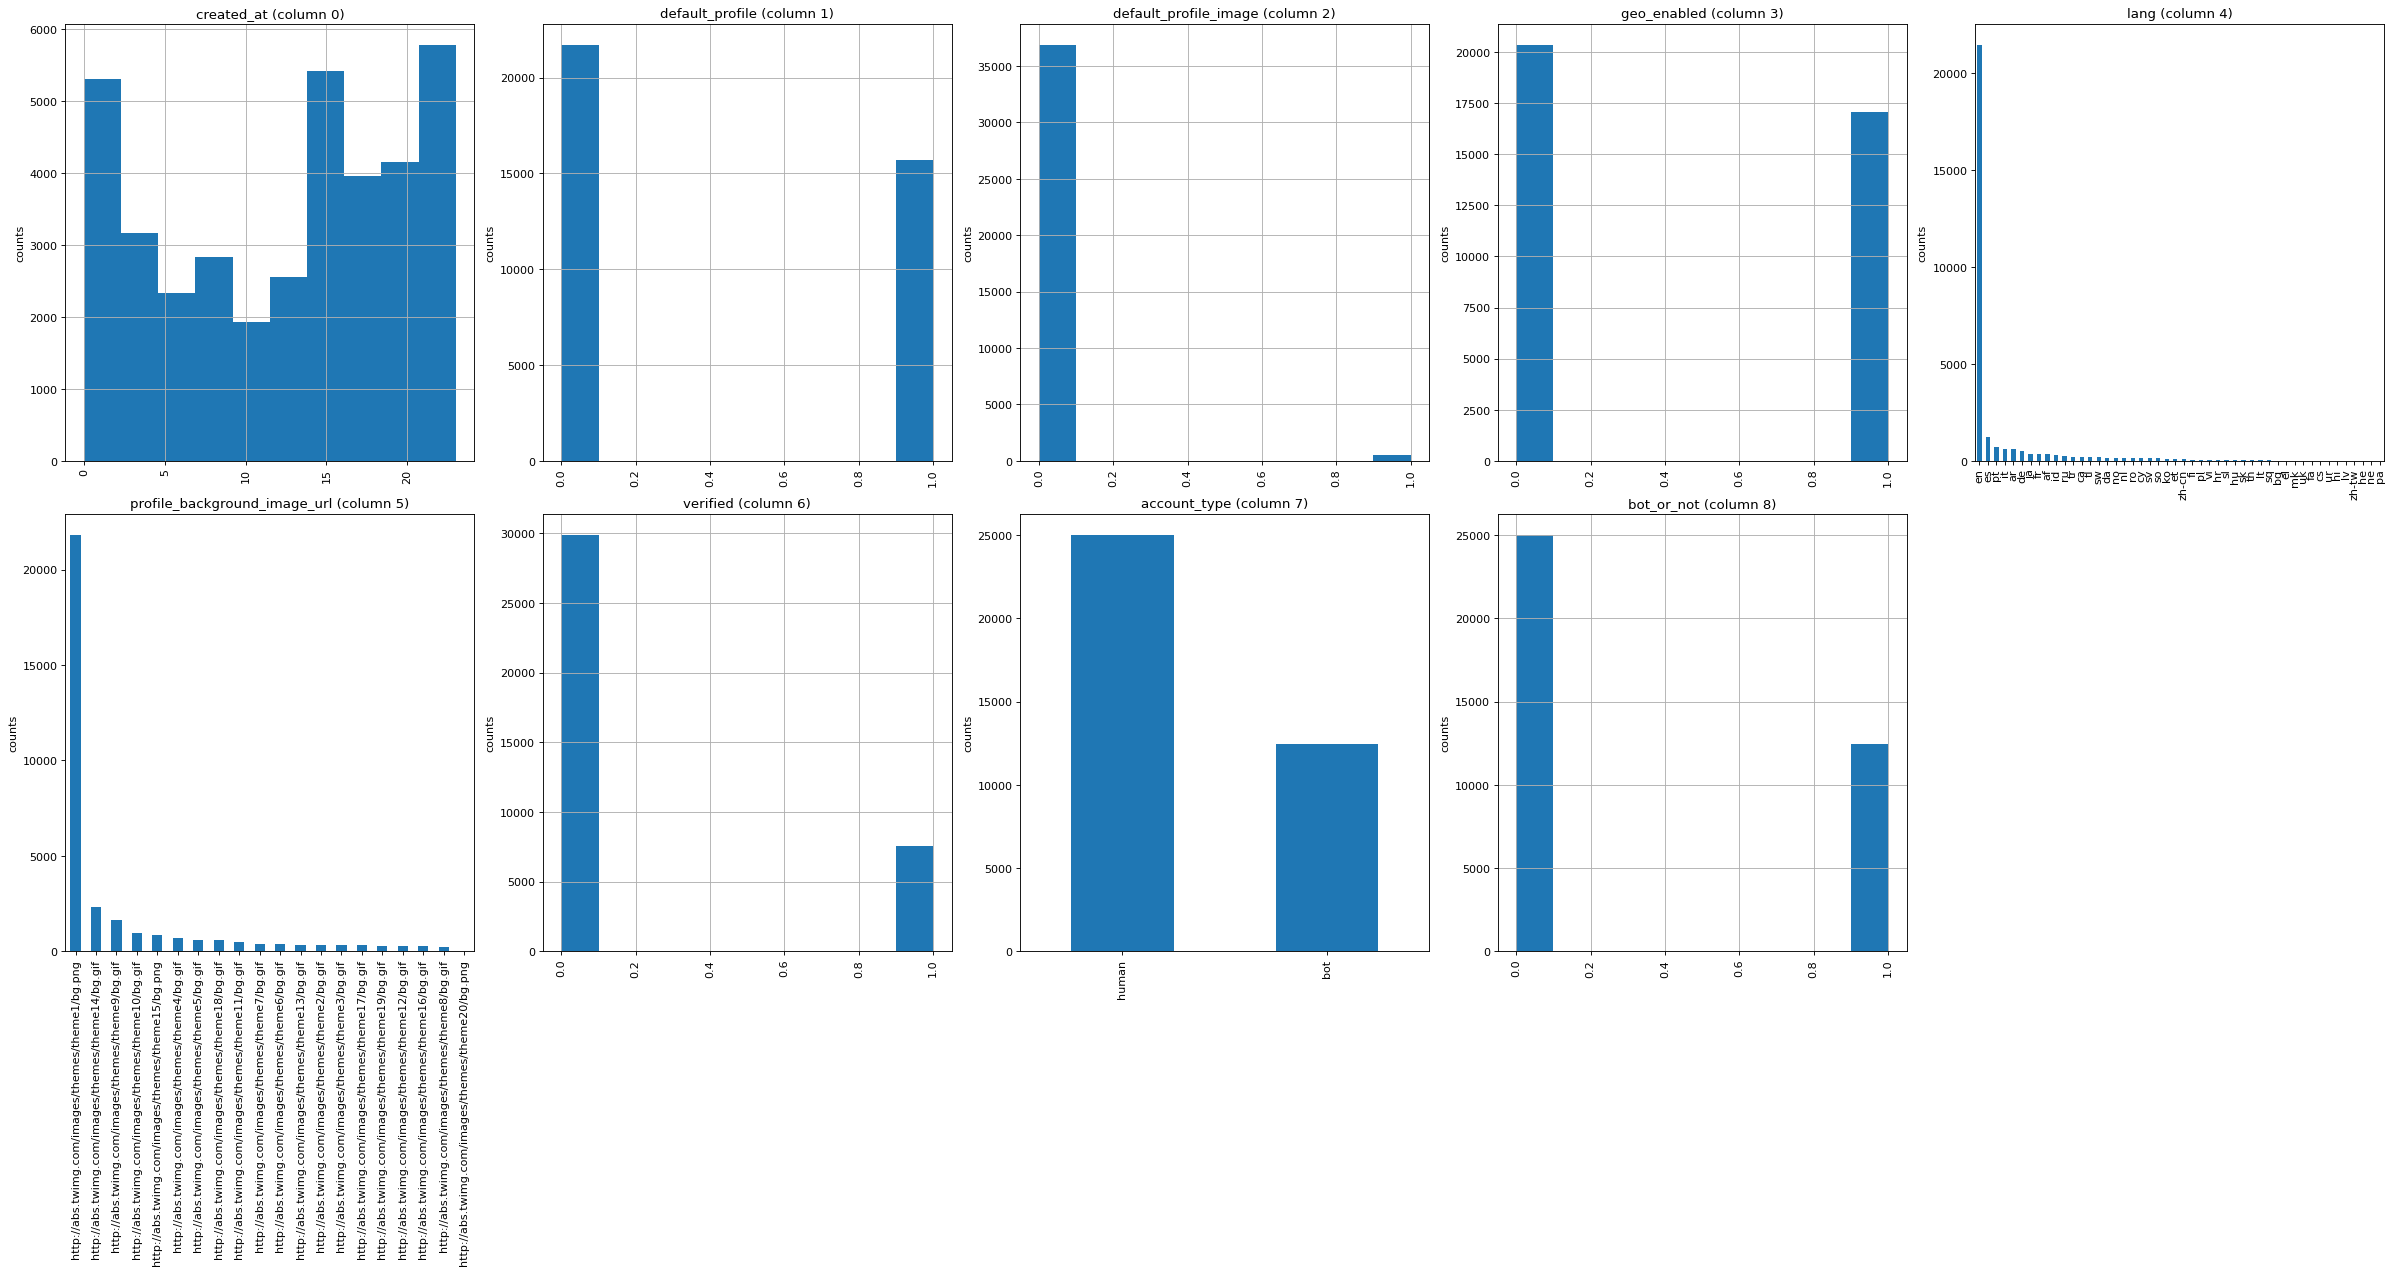

In [22]:
plotPerColumnDistribution(df, 10, 5)

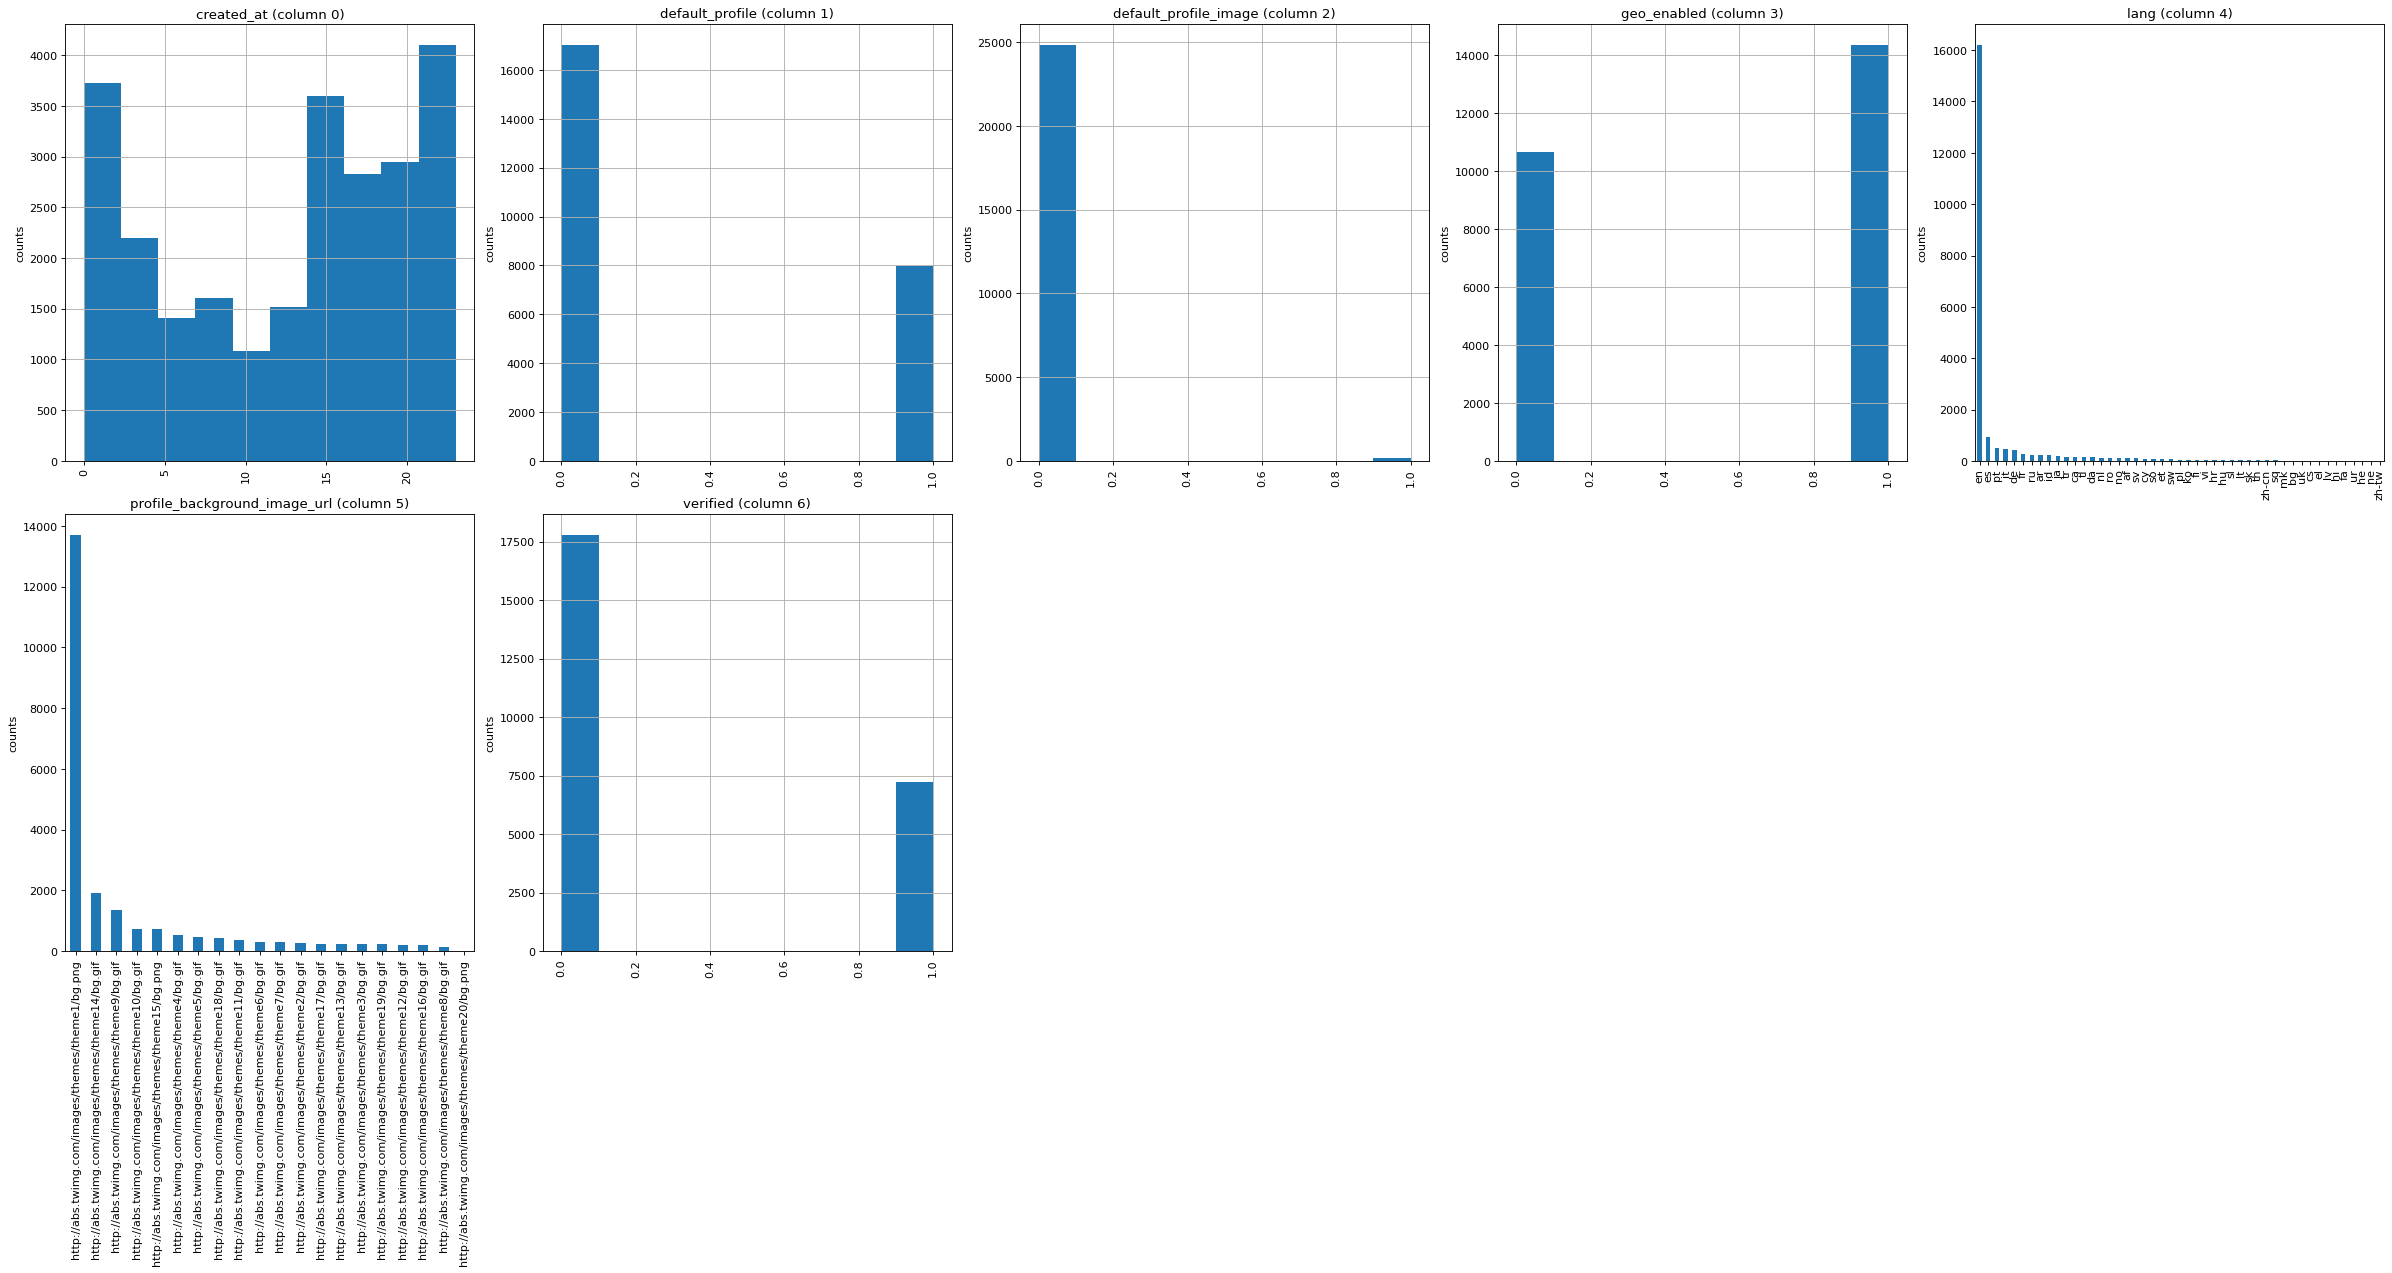

In [23]:
plotPerColumnDistribution(human_df, 10, 5)

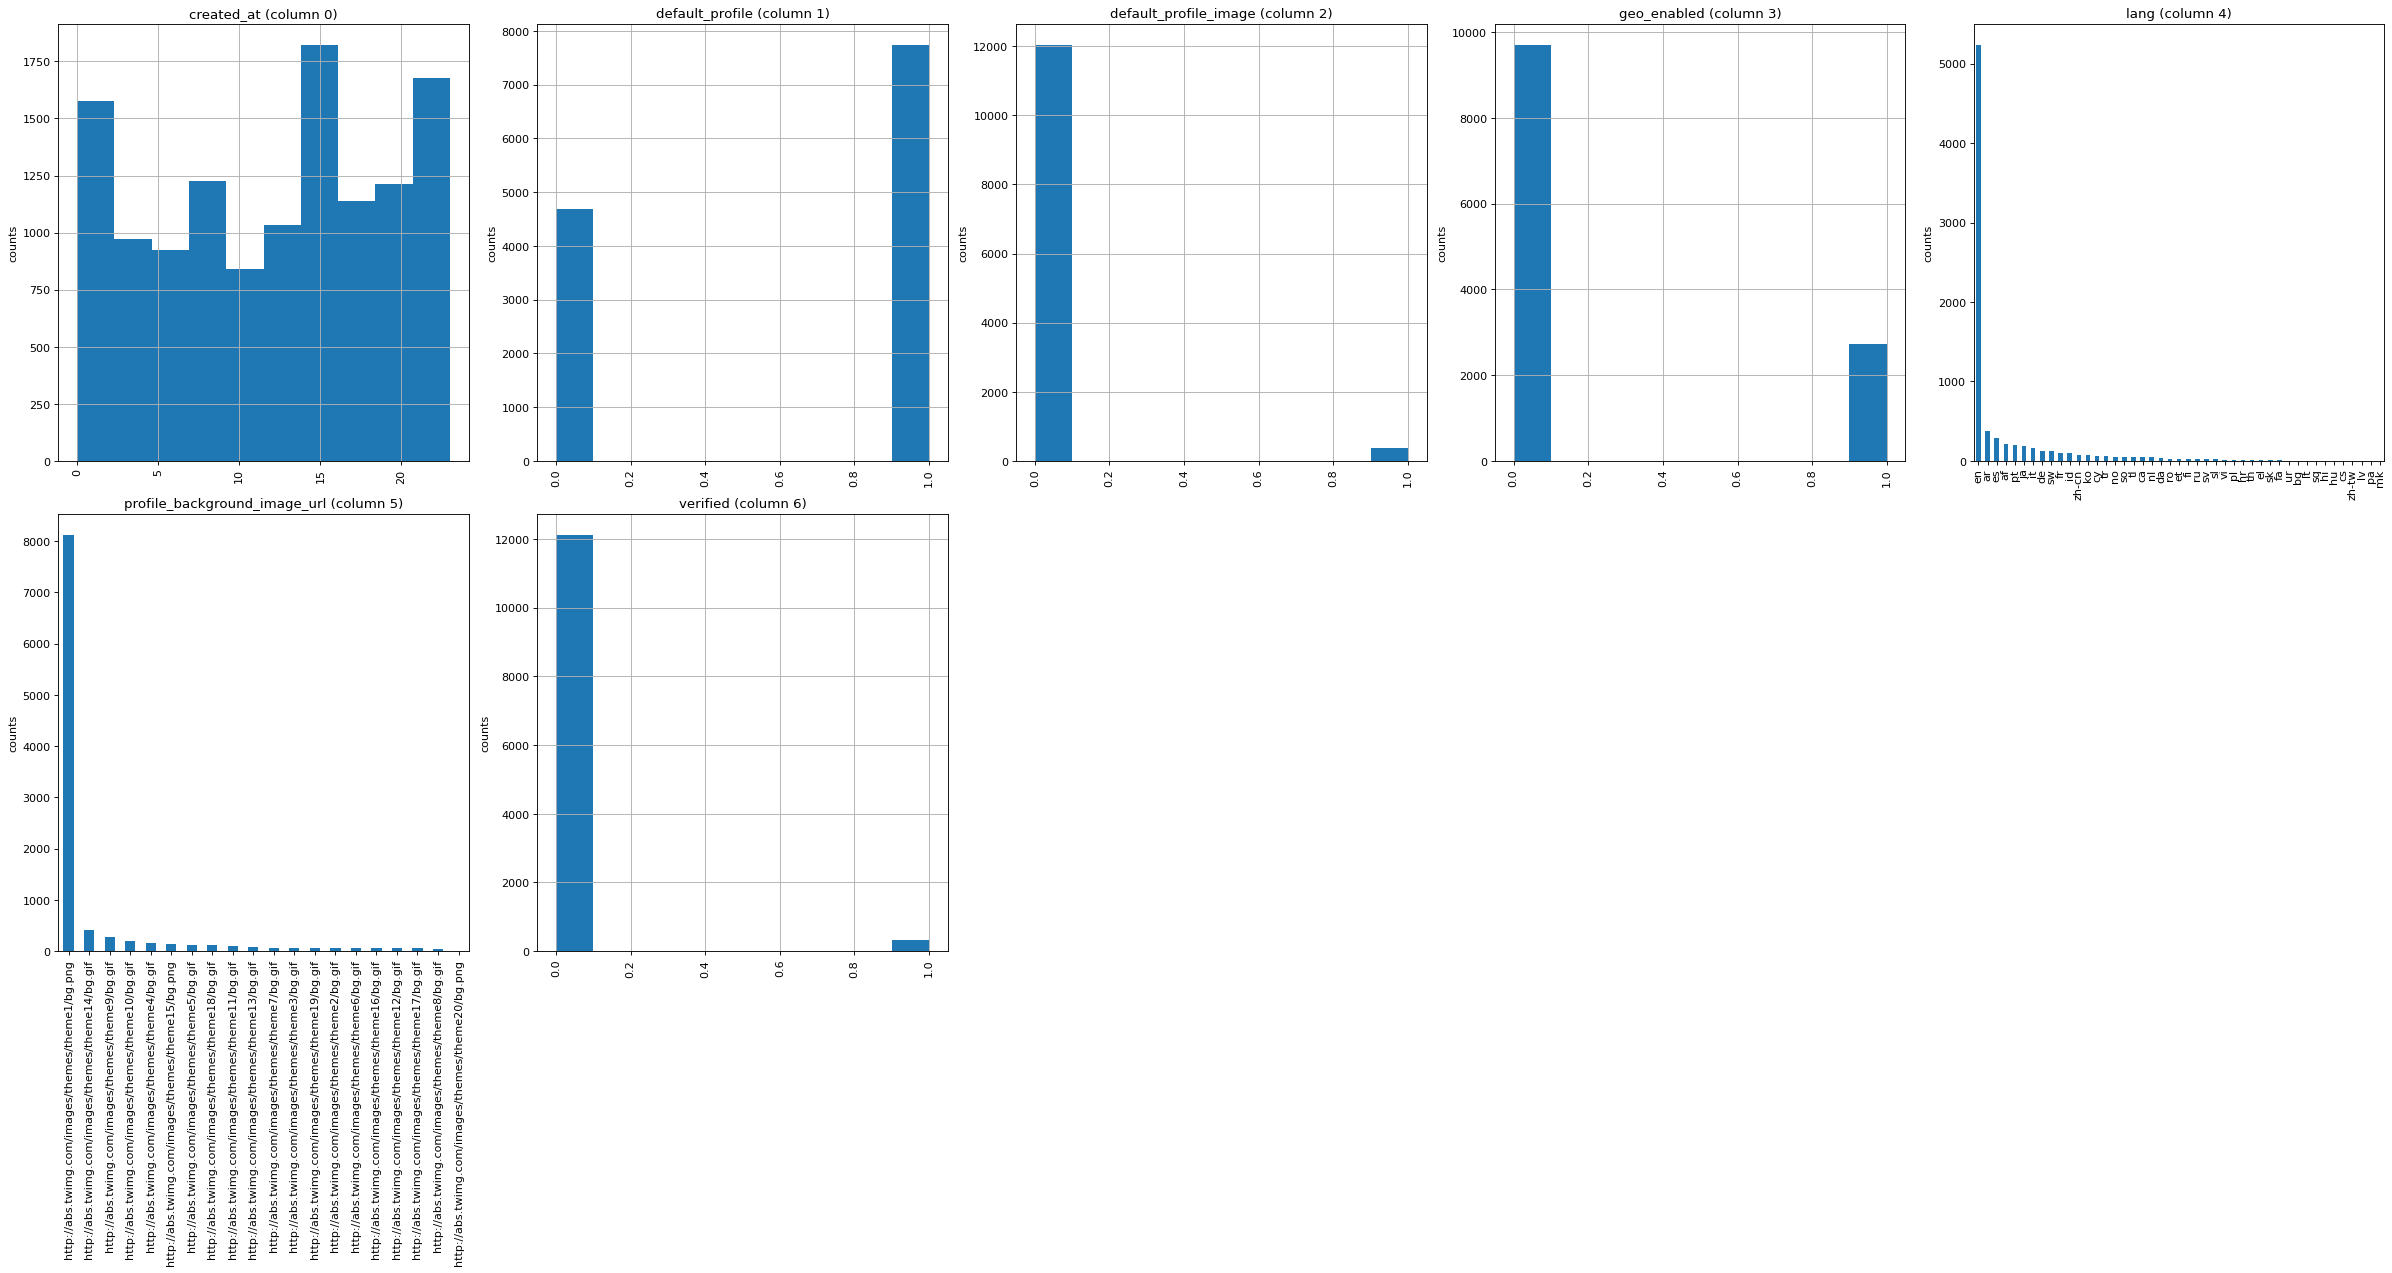

In [24]:
plotPerColumnDistribution(bot_df, 10, 5)

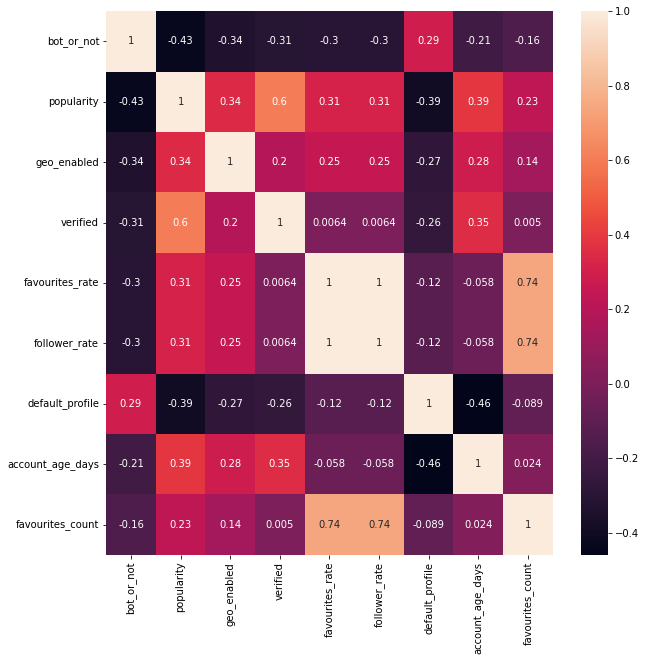

In [25]:
plotCorrelationMatrix(df)

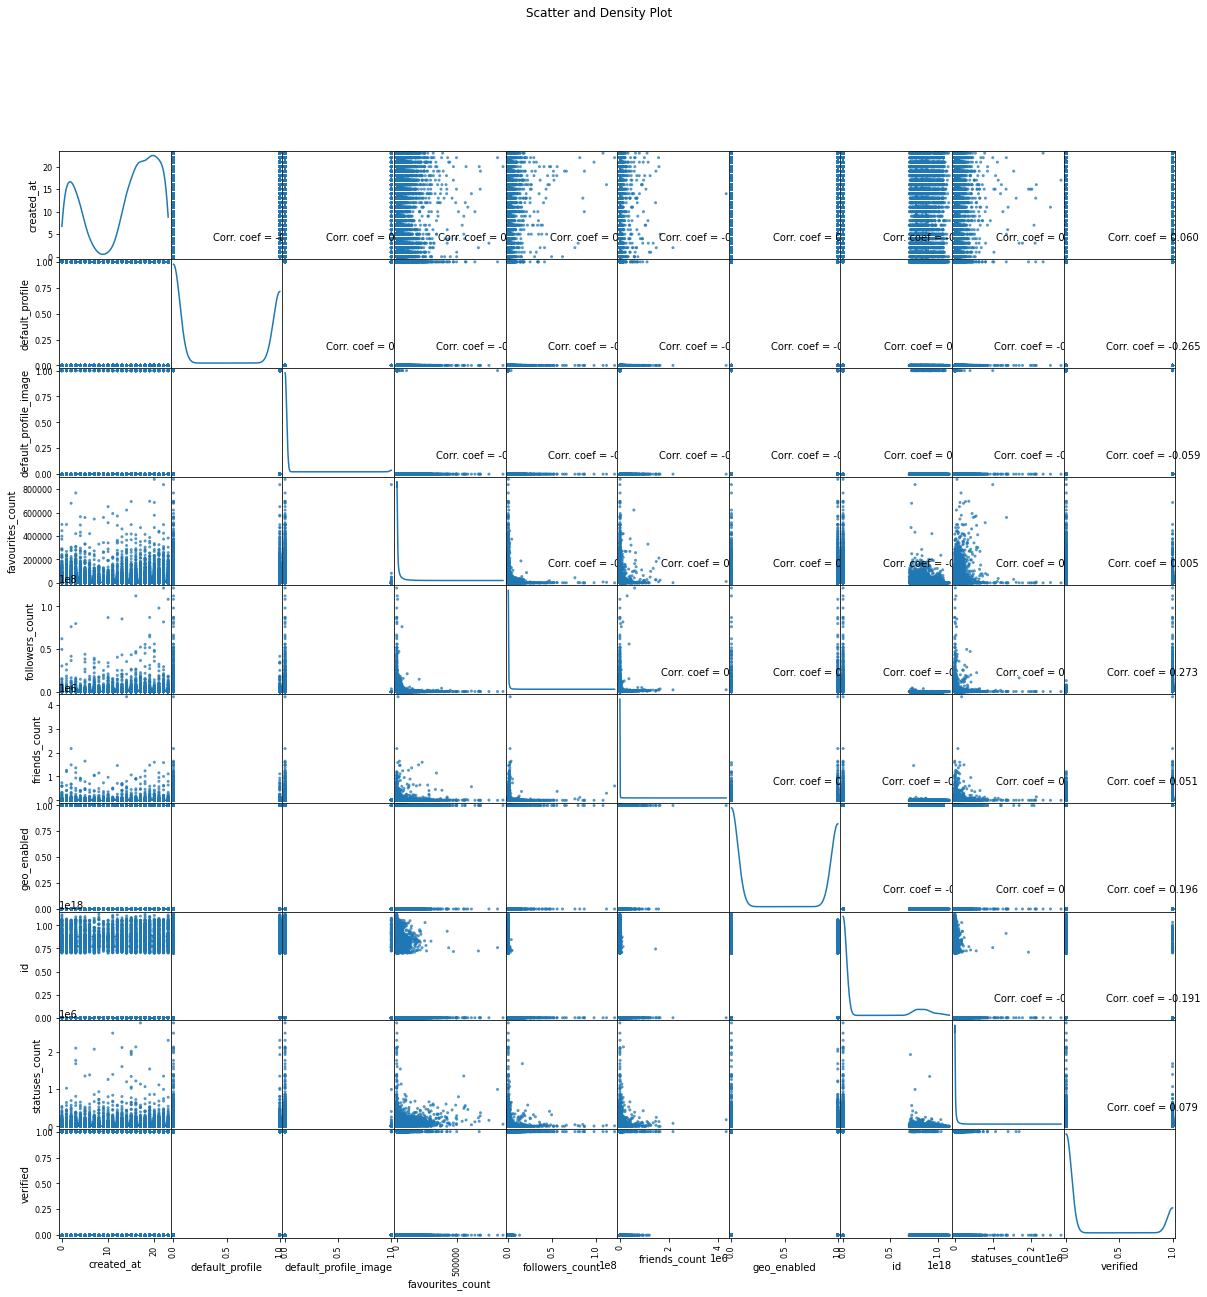

In [26]:
plotScatterMatrix(df, 20, 10)

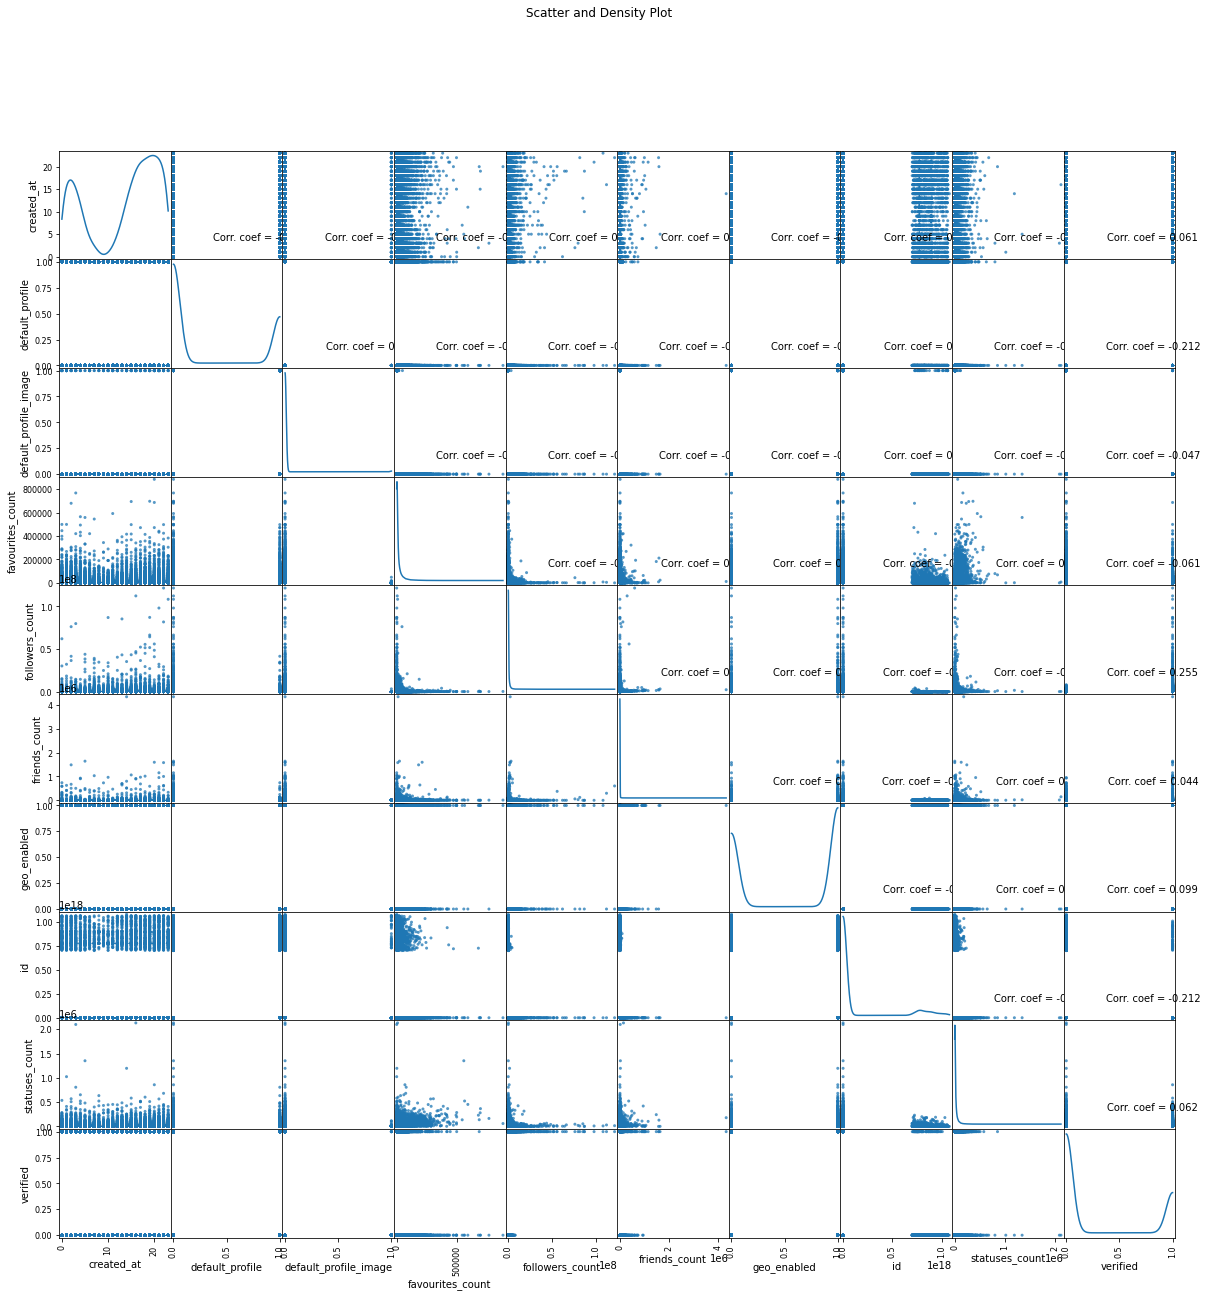

In [27]:
plotScatterMatrix(human_df, 20, 10)

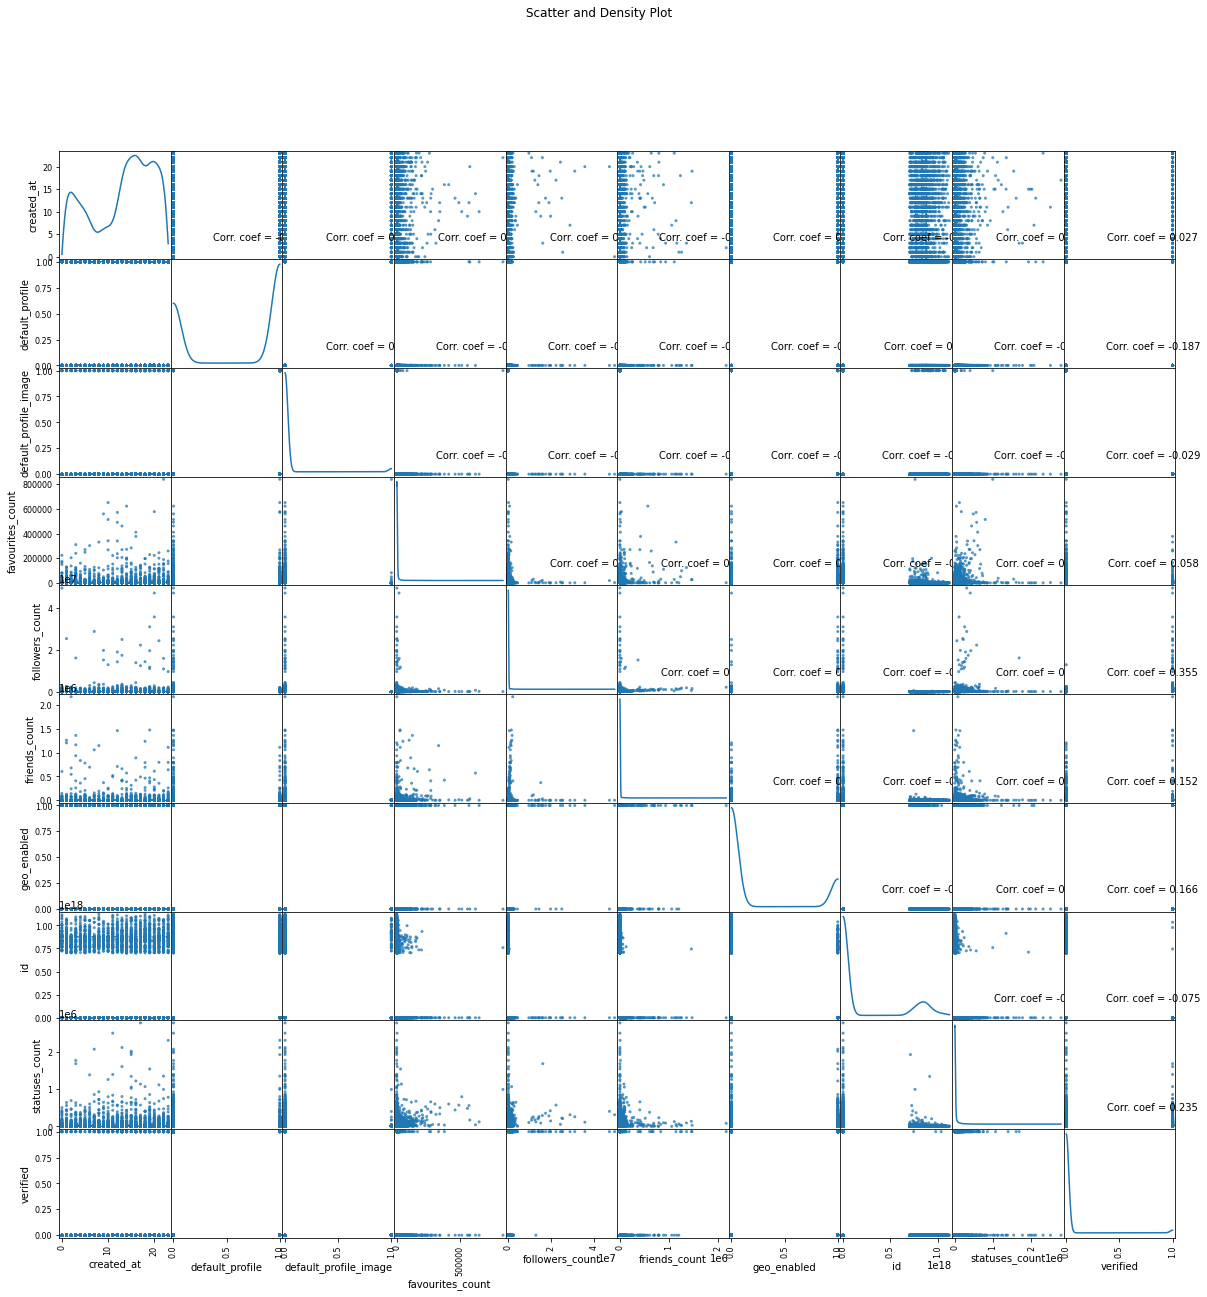

In [28]:
plotScatterMatrix(bot_df, 20, 10)

In [29]:
# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(
    df=df, column=grouped, palette=palette)

### Observation 3: human account are more popular than bot

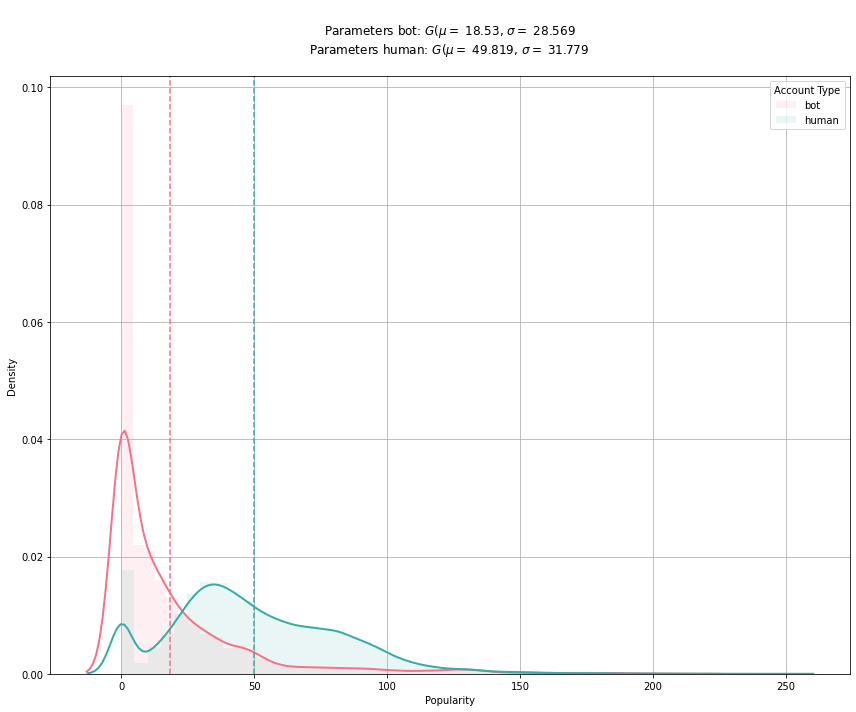

In [30]:
target: str = "popularity"  
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

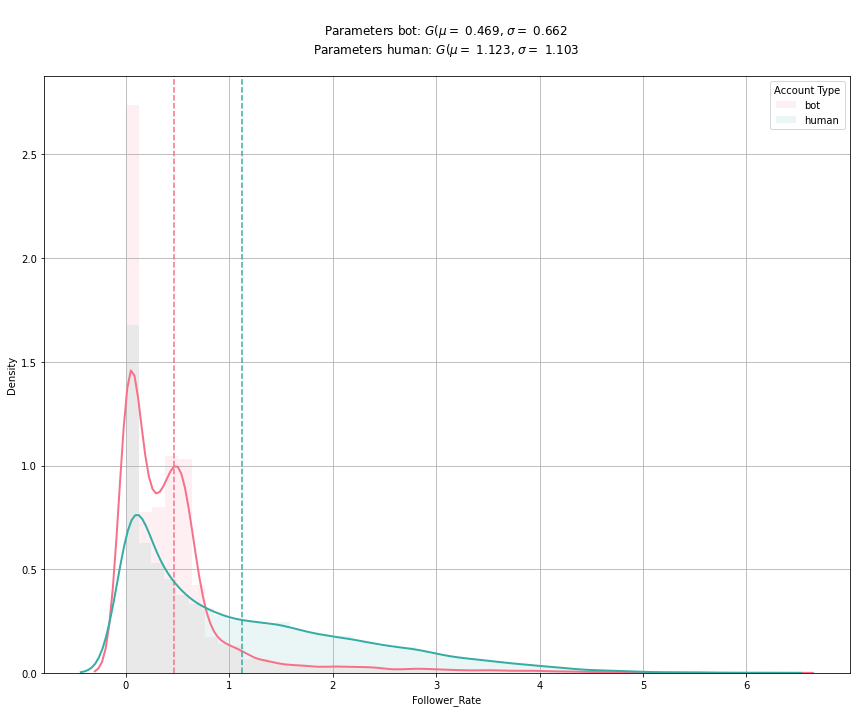

In [31]:
target: str = 'follower_rate'
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

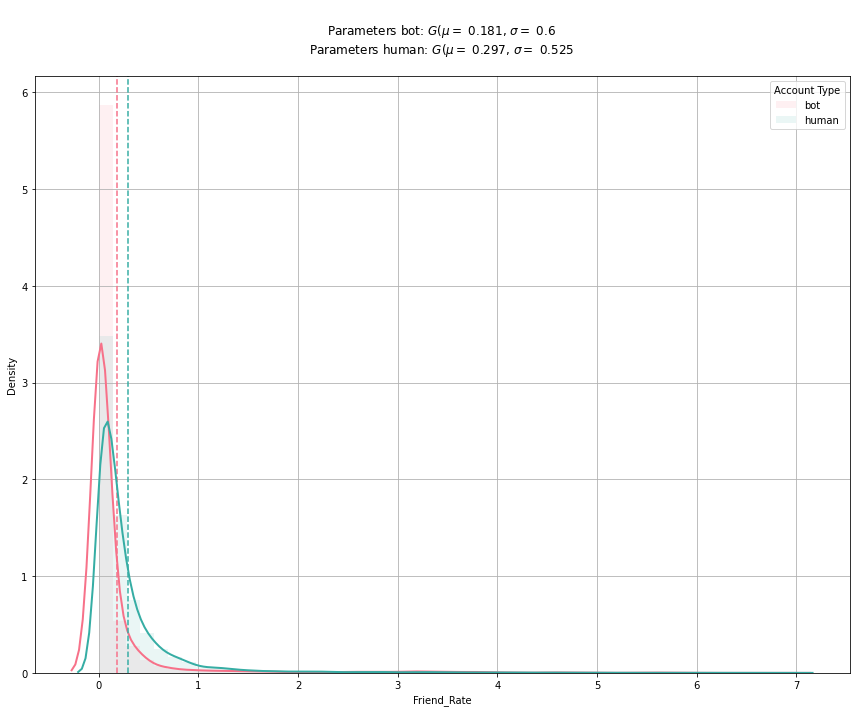

In [32]:
target: str = 'friend_rate'
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

### Observation 4: human has higher favourites rate than bot, no significant difference on average tweets per day

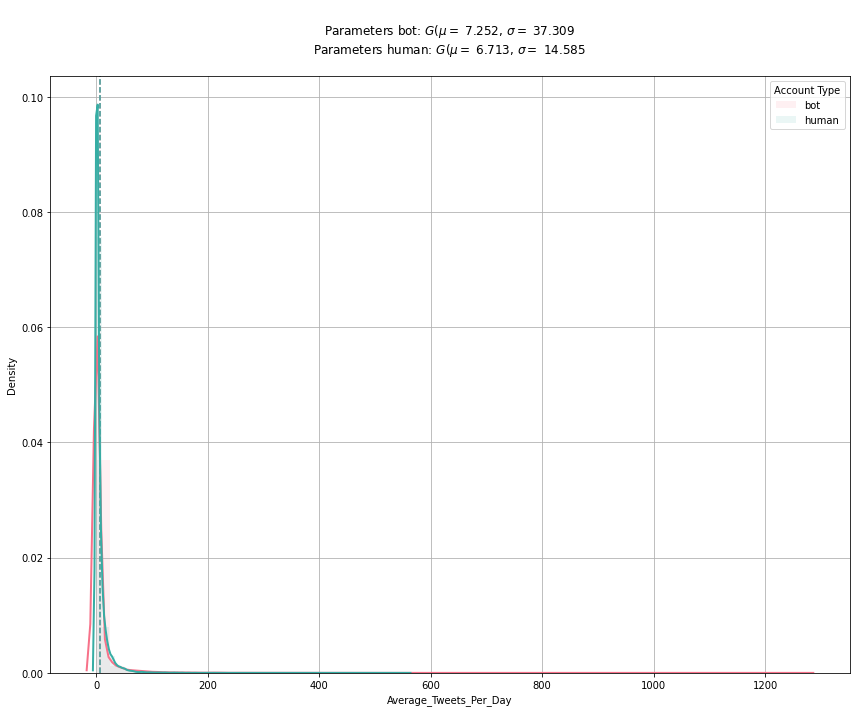

In [33]:
target: str = "average_tweets_per_day"  
# Extract histograms
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

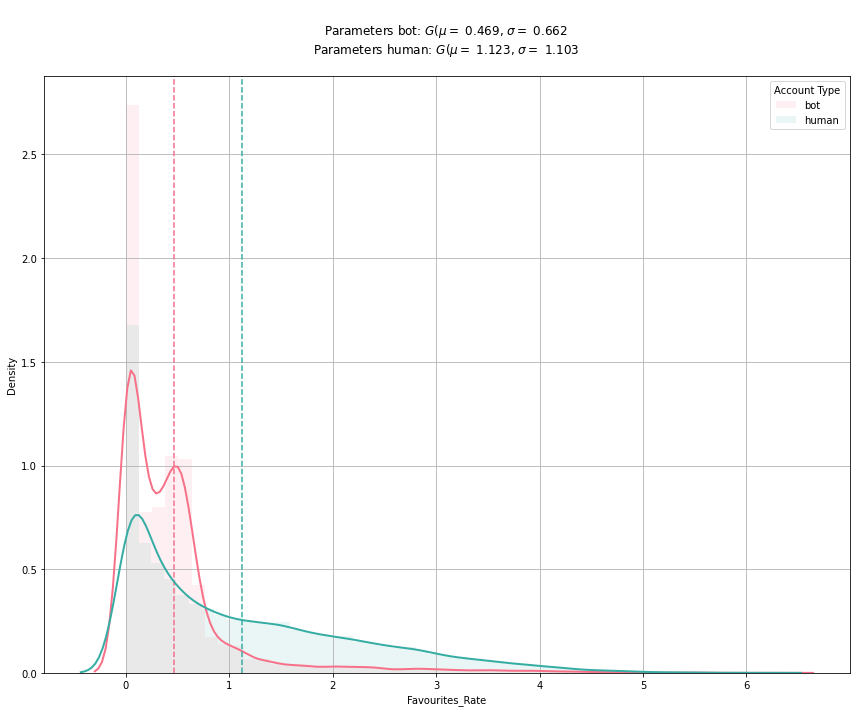

In [34]:
target: str = "favourites_rate"  
# Extract histograms
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

### Observation 5: bot account creation time distributed evenly, human account creation time has peak and bottom

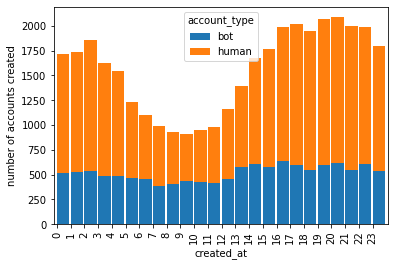

In [35]:
create_time_bar(df)

### Observation 6: human verified much more than bot

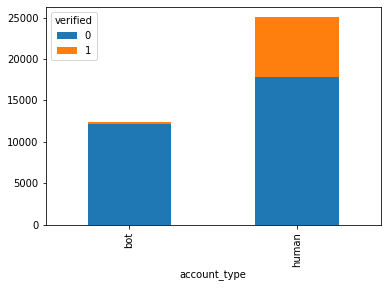

In [36]:
verified_bar(df)

In [37]:
len(human_df.loc[human_df['verified']==1])/len(human_df)

0.2892495902130892

In [38]:
len(bot_df.loc[bot_df['verified']==1])/len(bot_df)

0.025432595573440644

## Save Data for Model Implementation



In [39]:
df.to_csv('data.csv')